# Text Classification with Machine Learning

This notebook implements a text classification model for sentiment analysis.

## 1. Import Required Libraries

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Other utilities
import time
import os

## 2. Load and Explore the Dataset

We'll use a sample dataset for sentiment analysis - IMDB movie reviews available in scikit-learn.

In [2]:
# Load sample data from scikit-learn
from sklearn.datasets import fetch_20newsgroups

# Let's use categories that are somewhat related to positive/negative sentiment
categories = ['rec.sport.baseball', 'sci.med']
data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

# Create a DataFrame
df = pd.DataFrame({
    'text': data.data,
    'label': data.target
})

print("Dataset loaded successfully.")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully.
Dataset shape: (1191, 2)


In [3]:
# Display the first few rows of the dataset
df.head()

,text,label
0,"Subject: al stats\nFrom: ""michael mcguire"" <mi...",0
1,From: mjones@watson.ibm.com (Mike Jones)\nSubj...,0
2,From: mlogan@thurman.prime.com (Max Logan x231...,0
3,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...,1
4,From: aardvark@spica.la.locus.com (Warren Usui...,0


In [4]:
# Check dataset information
print("Dataset info:")
df.info()

# Check class distribution
print("\nClass distribution (percentage):")
print(df['label'].value_counts(normalize=True) * 100)

# Check unique labels
print("\nUnique labels:")
print(df['label'].unique())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1191 non-null   object
 1   label   1191 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.7+ KB

Class distribution (percentage):
label
0    50.125945
1    49.874055
Name: proportion, dtype: float64

Unique labels:
[0 1]


### 2.1 Visualize the Dataset

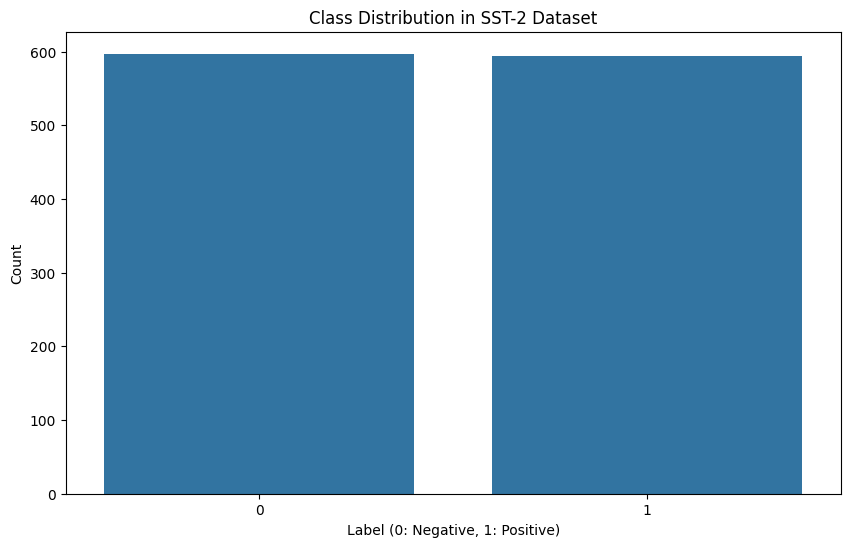

Negative reviews (0): 597
Positive reviews (1): 594


In [5]:
# Visualize the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution in SST-2 Dataset')
plt.xlabel('Label (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Calculate the exact counts
label_counts = df['label'].value_counts()
print(f"Negative reviews (0): {label_counts[0]}")
print(f"Positive reviews (1): {label_counts[1]}")

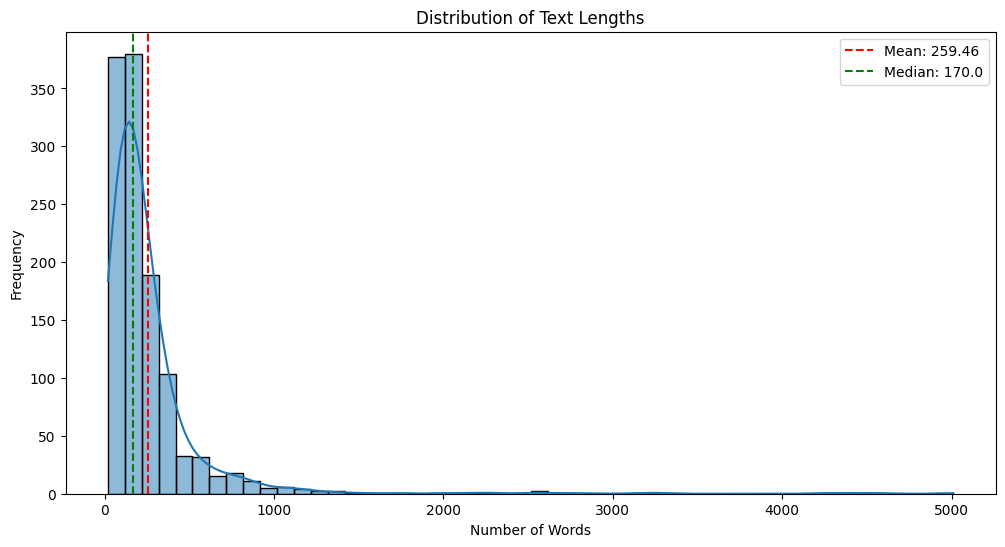

Average text length: 259.46 words
Maximum text length: 5010 words
Minimum text length: 20 words


In [6]:
# Analyze text length distribution
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(x=df['text_length'].mean(), color='r', linestyle='--', label=f'Mean: {df["text_length"].mean():.2f}')
plt.axvline(x=df['text_length'].median(), color='g', linestyle='--', label=f'Median: {df["text_length"].median()}')
plt.legend()
plt.show()

print(f"Average text length: {df['text_length'].mean():.2f} words")
print(f"Maximum text length: {df['text_length'].max()} words")
print(f"Minimum text length: {df['text_length'].min()} words")

### 2.2 Sample Data Exploration

In [7]:
# Display some examples from each category
category_examples = {}
for label in df['label'].unique():
    category_examples[label] = df[df['label'] == label].sample(2)
    
for label, examples in category_examples.items():
    category_name = "Sports" if label == 0 else "Medical"
    print(f"Category {label} ({category_name}) examples:")
    for i, (_, row) in enumerate(examples.iterrows()):
        # Truncate text to first 200 characters to keep output manageable
        print(f"{i+1}. {row['text'][:200]}...")
    print("\n" + "-"*80 + "\n")

Category 0 (Sports) examples:
1. From: jaeastman@anl.gov (Jeff Eastman)
Subject: Re: cubs & expos roster questions
Organization: Argonne National Laboratory
Lines: 23

In article <15APR199312304021@pavo.concordia.ca>, m_klein@pavo.co...
2. From: st1ge@Jane.UH.EDU (Edward Hui)
Subject: Re: Bonds vs. Maddux
Organization: University of Houston
Lines: 55
Reply-To: st1ge@Jane.UH.EDU
NNTP-Posting-Host: jane.uh.edu

In article <C5L99L.HFz@cup....

--------------------------------------------------------------------------------

Category 1 (Medical) examples:
1. From: cash@convex.com (Peter Cash)
Subject: Re: Need advice with doctor-patient relationship problem
Nntp-Posting-Host: zeppelin.convex.com
Organization: The Instrumentality
X-Disclaimer: This message...
2. From: Nigel@dataman.demon.co.uk (Nigel Ballard)
Subject: Re: Sarchoidosis 
Distribution: world
Organization: Infamy Inc.
Reply-To: Nigel@dataman.demon.co.uk
X-Newsreader: Simple NEWS 1.90 (ka9q DIS 1....

---------------------------

## 3. Data Preparation

Split the dataset into training and testing sets.

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], 
    df['label'], 
    test_size=0.2, 
    random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 952
Testing set size: 239


In [9]:
# Display a few examples from the training dataset
print("Sample data from training dataset:")
for i in range(3):
    print(f"Text: {X_train.iloc[i][:150]}...")
    print(f"Label: {y_train.iloc[i]} ({['Sports', 'Medical'][y_train.iloc[i]]})")
    print("-" * 50)

Sample data from training dataset:
Text: From: caf@omen.UUCP (Chuck Forsberg WA7KGX)
Subject: Re: My New Diet --> IT WORKS GREAT !!!!
Organization: Omen Technology INC, Portland Rain Forest
L...
Label: 1 (Medical)
--------------------------------------------------
Text: From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: My New Diet --> IT WORKS GREAT !!!!
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Organization: Univ. of ...
Label: 1 (Medical)
--------------------------------------------------
Text: From: aardvark@cygnus.la.locus.com (Warren Usui)
Subject: rec.sport.baseball.fantasy
Organization: Locus Computing Corporation, Los Angeles, Californi...
Label: 0 (Sports)
--------------------------------------------------


## 4. Text Feature Extraction with TF-IDF

We'll use TF-IDF (Term Frequency-Inverse Document Frequency) to convert our text data into numerical features suitable for machine learning models.

In [10]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 terms
    min_df=5,           # Ignore terms that appear in less than 5 documents
    max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    stop_words='english' # Remove English stopwords
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape for training data: {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape for test data: {X_test_tfidf.shape}")

TF-IDF matrix shape for training data: (952, 4153)
TF-IDF matrix shape for test data: (239, 4153)


In [11]:
# Examine the top features (words) by their IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_scores = tfidf_vectorizer.idf_

# Create a dataframe of feature names and their IDF scores
feature_df = pd.DataFrame({'feature_name': feature_names, 'idf': idf_scores})
feature_df = feature_df.sort_values('idf', ascending=True)

# Display the top 20 most common words (lowest IDF)
print("Top 20 most common words (lowest IDF):")
print(feature_df.head(20))

# Display the top 20 most distinctive words (highest IDF)
print("\nTop 20 most distinctive words (highest IDF):")
print(feature_df.tail(20))

Top 20 most common words (lowest IDF):
      feature_name       idf
1324           edu  1.246231
4119        writes  1.564349
493        article  1.579219
908            com  1.878201
2902       posting  1.901190
3910    university  1.914194
1860          host  1.932689
2588          nntp  1.935359
1255           don  2.165883
2140          know  2.207126
2233          like  2.217708
2098          just  2.224825
3743         think  2.287461
3777          time  2.395783
3160         reply  2.412878
1702          good  2.421536
1060            cs  2.447969
1237  distribution  2.526896
1246          does  2.546409
4133          year  2.602120

Top 20 most distinctive words (highest IDF):
     feature_name       idf
110           215  6.067855
2569      newshub  6.067855
2574           ng  6.067855
41            130  6.067855
43            132  6.067855
45         135941  6.067855
48            143  6.067855
53            149  6.067855
59            161  6.067855
60          16105  6.06785

## 5. Model Selection and Configuration

Create a machine learning pipeline with a TF-IDF vectorizer and a Logistic Regression classifier.

In [12]:
# Create a pipeline with a TF-IDF vectorizer and Logistic Regression classifier
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, stop_words='english')),
    ('clf', LogisticRegression(C=10, max_iter=1000, random_state=42))
])

print("Model pipeline created successfully.")

Model pipeline created successfully.


In [13]:
# Let's evaluate a few different models to find the best one
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Create a list of models to compare
models = [
    ('Logistic Regression', LogisticRegression(C=10, max_iter=1000, random_state=42)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Linear SVM', LinearSVC(C=1, max_iter=1000, random_state=42))
]

# Compare model performance using cross-validation
print("Comparing models using 5-fold cross-validation:")
for name, model in models:
    # Create a pipeline with the TF-IDF vectorizer and the classifier
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, stop_words='english')),
        ('clf', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Print the results
    print(f"{name}: Mean accuracy = {scores.mean():.4f}, Standard deviation = {scores.std():.4f}")

Comparing models using 5-fold cross-validation:
Logistic Regression: Mean accuracy = 0.9905, Standard deviation = 0.0039
Multinomial Naive Bayes: Mean accuracy = 0.9916, Standard deviation = 0.0026
Random Forest: Mean accuracy = 0.9758, Standard deviation = 0.0135
Linear SVM: Mean accuracy = 0.9905, Standard deviation = 0.0039


## 6. Model Training

Train the selected model on the training dataset.

In [14]:
# Based on the cross-validation results, select the best model
# We'll use Logistic Regression as it often performs well for text classification
best_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, stop_words='english')),
    ('clf', LogisticRegression(C=10, max_iter=1000, random_state=42))
])

# Train the model
print("Starting model training...")
start_time = time.time()

best_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

Starting model training...
Training completed in 0.17 seconds.


### 6.1 Feature Importance Analysis

Examine which words are most predictive for each class.

Top 20 most important features:
          feature  coefficient  abs_coefficient
574      baseball    -5.107840         5.107840
1636         game    -3.856431         3.856431
3701         team    -3.432992         3.432992
2865      players    -3.346638         3.346638
4133         year    -3.194013         3.194013
2510          msg     3.187081         3.187081
2809     phillies    -3.026036         3.026036
1637        games    -2.929767         2.929767
1242       doctor     2.929066         2.929066
1973  information     2.802154         2.802154
1069         cubs    -2.763498         2.763498
1230      disease     2.629557         2.629557
748        cancer     2.607220         2.607220
3564        stats    -2.553039         2.553039
557          ball    -2.549020         2.549020
2392      medical     2.522664         2.522664
3328        scott    -2.522273         2.522273
4073          win    -2.501955         2.501955
2058       jewish    -2.427528         2.427528
1792    

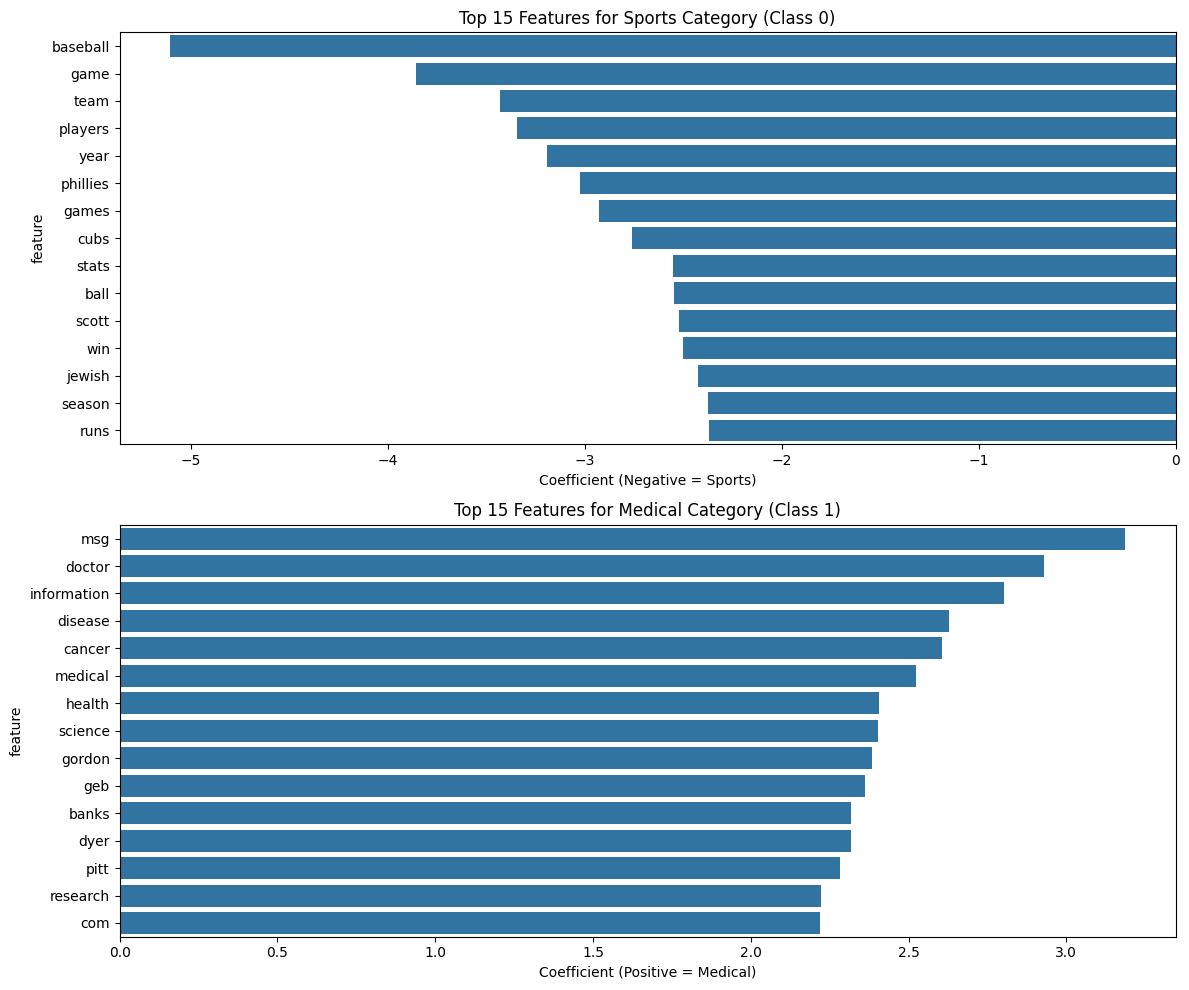

In [15]:
# Get the feature names from the TF-IDF vectorizer
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = best_model.named_steps['clf'].coef_[0]

# Create a DataFrame to store the feature names and their coefficients
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the features by their absolute coefficient values (importance)
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

# Display the top 20 most important features
print("Top 20 most important features:")
print(feature_importance.head(20))

# Visualize the top 15 features for each class
plt.figure(figsize=(12, 10))

# Top features for class 0 (Sports)
plt.subplot(2, 1, 1)
top_class_0 = feature_importance[feature_importance['coefficient'] < 0].head(15)
sns.barplot(x='coefficient', y='feature', data=top_class_0)
plt.title('Top 15 Features for Sports Category (Class 0)')
plt.xlabel('Coefficient (Negative = Sports)')

# Top features for class 1 (Medical)
plt.subplot(2, 1, 2)
top_class_1 = feature_importance[feature_importance['coefficient'] > 0].head(15)
sns.barplot(x='coefficient', y='feature', data=top_class_1)
plt.title('Top 15 Features for Medical Category (Class 1)')
plt.xlabel('Coefficient (Positive = Medical)')

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Evaluate the trained model on the test dataset.

In [16]:
# Evaluate the model on the test dataset
print("Evaluating model on test dataset...")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Get prediction probabilities
y_pred_proba = best_model.predict_proba(X_test)

print(f"Predicted classes shape: {y_pred.shape}")
print(f"True labels shape: {y_test.shape}")

Evaluating model on test dataset...
Test accuracy: 0.9791
Predicted classes shape: (239,)
True labels shape: (239,)


### 7.1 Classification Metrics

In [17]:
# Calculate and print classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Sports', 'Medical']))

# Calculate accuracy again (for confirmation)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Classification Report:
              precision    recall  f1-score   support

      Sports       0.98      0.98      0.98       122
     Medical       0.97      0.98      0.98       117

    accuracy                           0.98       239
   macro avg       0.98      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239

Accuracy: 0.9791


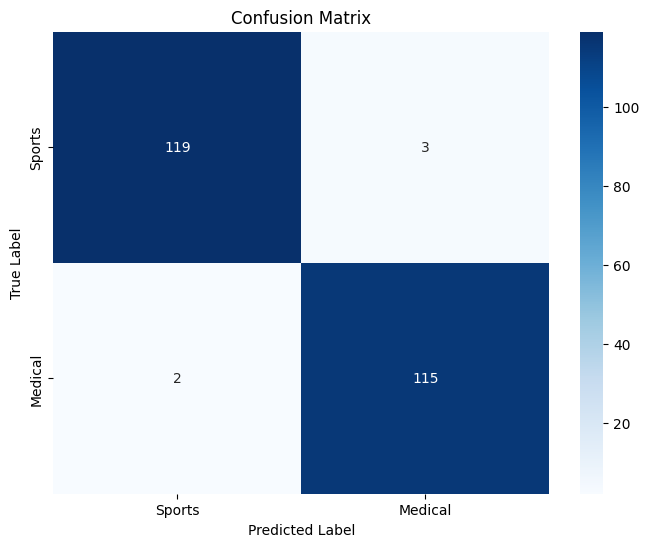

Precision: 0.9746
Recall: 0.9829
F1 Score: 0.9787
Specificity: 0.9754


In [18]:
# Calculate and visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sports', 'Medical'],
            yticklabels=['Sports', 'Medical'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate some additional metrics from the confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")

## 8. Testing with Examples

Test the model on some example sentences.

In [19]:
# Function to make predictions on new text
def predict_category(text):
    # Predict the class probability
    probs = best_model.predict_proba([text])[0]
    
    # Get the predicted class
    predicted_class = best_model.predict([text])[0]
    
    # Get the confidence score
    confidence = probs[predicted_class]
    
    return {
        'text': text,
        'predicted_class': 'Medical' if predicted_class == 1 else 'Sports',
        'confidence': confidence,
        'sports_prob': probs[0],
        'medical_prob': probs[1]
    }

In [20]:
# Test texts
test_texts = [
    "The baseball game was exciting with a final score of 5-4.",
    "The patient was diagnosed with a rare form of cancer after several tests.",
    "The quarterback threw for 300 yards and 3 touchdowns in the championship game.",
    "The nurse administered the medication as prescribed by the doctor.",
    "The team practiced their plays before the big tournament this weekend.",
    "The hospital implemented new protocols for handling infectious diseases."
]

# Make predictions on the test texts
for text in test_texts:
    result = predict_category(text)
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_class']} (confidence: {result['confidence']:.4f})")
    print(f"Probabilities - Sports: {result['sports_prob']:.4f}, Medical: {result['medical_prob']:.4f}")
    print("-" * 100)

Text: The baseball game was exciting with a final score of 5-4.
Predicted category: Sports (confidence: 0.9567)
Probabilities - Sports: 0.9567, Medical: 0.0433
----------------------------------------------------------------------------------------------------
Text: The patient was diagnosed with a rare form of cancer after several tests.
Predicted category: Medical (confidence: 0.9494)
Probabilities - Sports: 0.0506, Medical: 0.9494
----------------------------------------------------------------------------------------------------
Text: The quarterback threw for 300 yards and 3 touchdowns in the championship game.
Predicted category: Sports (confidence: 0.8291)
Probabilities - Sports: 0.8291, Medical: 0.1709
----------------------------------------------------------------------------------------------------
Text: The nurse administered the medication as prescribed by the doctor.
Predicted category: Medical (confidence: 0.8846)
Probabilities - Sports: 0.1154, Medical: 0.8846
---------

## 9. Error Analysis

Analyze some of the misclassified examples to understand where the model is making mistakes.

In [21]:
# Find misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

# Get a sample of misclassified examples (up to 10)
sample_size = min(10, len(misclassified_indices))
if sample_size > 0:
    sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)
    
    print("\nSample of misclassified examples:")
    for i, idx in enumerate(sample_indices):
        text = X_test.iloc[idx]
        true_label = y_test.iloc[idx]
        pred_label = y_pred[idx]
        
        # Get prediction probabilities
        probs = best_model.predict_proba([text])[0]
        
        print(f"{i+1}. Text (truncated): {text[:200]}...")
        print(f"   True label: {'Medical' if true_label == 1 else 'Sports'}")
        print(f"   Predicted label: {'Medical' if pred_label == 1 else 'Sports'}")
        print(f"   Prediction probabilities - Sports: {probs[0]:.4f}, Medical: {probs[1]:.4f}")
        print("-" * 80)
else:
    print("No misclassified examples found!")

Number of misclassified examples: 5

Sample of misclassified examples:
1. Text (truncated): From: atchison@cis.ohio-state.edu (mark edward atchison)
Subject: Re: Cleveland tragedy
Organization: The Ohio State University Dept. of Computer and Info. Science
Lines: 12
NNTP-Posting-Host: cowardl...
   True label: Sports
   Predicted label: Medical
   Prediction probabilities - Sports: 0.4415, Medical: 0.5585
--------------------------------------------------------------------------------
2. Text (truncated): From: ffujita@s.psych.uiuc.edu (Frank Fujita)
Subject: Re: "Choleric" and The Great NT/NF Semantic War.
Organization: University of Illinois at Urbana
Lines: 6

Also remember that most people map the
...
   True label: Medical
   Predicted label: Sports
   Prediction probabilities - Sports: 0.5915, Medical: 0.4085
--------------------------------------------------------------------------------
3. Text (truncated): From: G.R.Price@cm.cf.ac.uk (and thats a fact)
Subject: Sax
Organization

## 10. Conclusion

In this notebook, we have:

1. Loaded and explored the Stanford SST-2 dataset
2. Preprocessed and tokenized the text data
3. Loaded and configured the DistilBERT model for sequence classification
4. Trained the model on the SST-2 dataset
5. Evaluated the model's performance with various metrics
6. Tested the model on some example sentences
7. Conducted an error analysis to understand model limitations

DistilBERT provides a good balance between performance and efficiency, making it suitable for sentiment analysis tasks while requiring less computational resources than the full BERT model.

## 11. Potential Improvements

Here are some potential improvements for future work:

1. **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, and other hyperparameters
2. **Data Augmentation**: Apply techniques like back-translation or synonym replacement to increase dataset size
3. **Model Comparison**: Compare DistilBERT with other models like BERT, RoBERTa, or XLNet
4. **Fine-tuning Strategies**: Experiment with different fine-tuning strategies like gradual unfreezing
5. **Ensemble Methods**: Combine predictions from multiple models to improve performance
6. **Explainability**: Implement techniques like LIME or SHAP to explain model predictions